# PPO and A2C

**Note** : this script is inspired from the 1st assignment (without correction) from the RL course of the MVA master by A. Lazaric and M. Pirotta, on finite MDP and function approximation, which required to complete a partial implementation of A2C for discrete action space. It has been extended to include a different critic and actor architecture, continuous action space, and the clipped and adaptative KL losses required for PPO.

In [49]:
import os
import numpy as np
from pathlib import Path
from pprint import pprint
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from pprint import pprint

try :
    import Box2D
except :
    !pip install Box2D
import pickle as pkl

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
from torch.distributions import normal

import gym
from gym.wrappers import Monitor
from gym.spaces import Box, Discrete

# from pyvirtualdisplay import Display
# from IPython import display as ipythondisplay
# from IPython.display import clear_output
# import base64

######################## Import internal modules 

# import utils

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print("using GPU" if device.type=="cuda" else "using CPU" )
#print("Device name: ", torch.cuda.get_device_name())
device = 'cpu'

In [50]:
try :
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd /content/drive/My\ Drive/RL-PPO
except :
    print("Script running locally")

Script running locally


## Setup the environment
See https://github.com/openai/gym/wiki/Leaderboard for description of OpenAIGym environments

Discrete control settings : 
* "Taxi-v3" : episodic & discrete setting both for states and actions (S/N/E/W/Pickup/Dropoff)
* __"CartPole-v0" / "CartPole-v1" : discrete action and continuous state space__
* __"MountainCar-v0" : discrete action and continuous state space__

Continous control settings :
* __"MountainCarContinuous-v0" (both state and action continuous spaces)__
* "LunarLanderContinuous-v2" (requires box2D)
* "CarRacing-v0" : "Discrete control is reasonable in this environment as well" (requires box2D)

* "MsPacman-v0 "(requires the Atari dependency)

Settings used by the authors (requires the MuJoCo dependencies, 30 days free trial) : https://github.com/openai/mujoco-py
* "HalfCheetah-v1" (use v2 now?)
* "Hopper-v1"
* etc.

## Configuration 

See https://github.com/llSourcell/Unity_ML_Agents/blob/master/docs/best-practices-ppo.md for tuning best practice

In [51]:
def reset_config(print_=False):
    config = {}
    config['env'] = 'CartPole-v1'
    #config['env'] = 'MountainCarContinuous-v0'
    #config['env'] = 'LunarLander-v2'
    #config['env'] = 'MountainCar-v0'

    config['std'] = 0.001 # use constant standard deviation for continuous action space (for now)
    config['gamma'] = 0.99 #Discount rate
    config['lambda'] = 1 # parameter of the generalized advantage estimation
    config['value_network'] = {'lr': 1e-3}
    config['actor_network'] = {'lr': 1e-3}
    config['eps_clipping'] = 0.2 #range : 0.1-0.3
    config['d_targ'] = 0.01
    config['beta_KL'] = 3
    config['c1'] = 1 #paramter of the value function loss
    config['c2'] = 1e-3 #entropy parameter --> 1e-4 to 1e-2
    config["reward_norm"]=False 
    config['epochs'] = 4
    config['max_episodes'] = 1000
    config['max_steps'] = 300
    config['optimize_every'] = 2048
    config['batch_size'] = 2048 #512-5120 for continuous / 32-512 for discrete
    config["randomize_batch"]=False
    # config['buffer_size'] = 2048 #2048 - 409600 /!\ multiple of the batch size
    config['loss_name'] = ["A2C_loss","adaptative_KL_loss","clipped_loss"][2]
    config['color'] = {"A2C_loss":sns.color_palette("Set2")[0],"adaptative_KL_loss":sns.color_palette("Set2")[1],"clipped_loss":sns.color_palette("Set2")[2]}

    config['seed'] = 42
    config["reset_val"] = None # use to reset the environment with a custom value
    config["solved_reward"] = {'LunarLander-v2':230,
                              'MountainCarContinuous-v0':300,
                              'CartPole-v1':300,
                              'MountainCar-v0':300}
    
    if print_== True :
        print("Training config : \n")
        pprint(config)
    return config

In [52]:
## reset configuration
config = reset_config(print_=True)

Training config : 

{'actor_network': {'lr': 0.001},
 'batch_size': 2048,
 'beta_KL': 3,
 'c1': 1,
 'c2': 0.001,
 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118),
           'adaptative_KL_loss': (0.9882352941176471,
                                  0.5529411764705883,
                                  0.3843137254901961),
           'clipped_loss': (0.5529411764705883,
                            0.6274509803921569,
                            0.796078431372549)},
 'd_targ': 0.01,
 'env': 'CartPole-v1',
 'epochs': 4,
 'eps_clipping': 0.2,
 'gamma': 0.99,
 'lambda': 1,
 'loss_name': 'clipped_loss',
 'max_episodes': 1000,
 'max_steps': 300,
 'optimize_every': 2048,
 'reset_val': None,
 'reward_norm': False,
 'seed': 42,
 'solved_reward': {'CartPole-v1': 300,
                   'LunarLander-v2': 230,
                   'MountainCar-v0': 300,
                   'MountainCarContinuous-v0': 300},
 'std': 0.001,
 'value_network': {'lr': 0.001}}


In [5]:
## Define environment 
env = gym.make(config['env'])
print(config["env"])
## Save episode
# env = Monitor(env, "./gym-results", force=True)

## Action and state spaces
print("State Space : {}".format(env.observation_space))
if isinstance(env.observation_space, Box) :
    print("continuous state space") 
    print("Lower bound : ", env.observation_space.low)
    print("Upper bound : ", env.observation_space.high)
else :
    print("discrete state space")

print("\nAction Space : {}".format(env.action_space))
if isinstance(env.action_space, Box):
    print("continuous action space") 
    print("Lower bound : ", env.action_space.low)
    print("Uppder bound : ", env.action_space.high)
else :
    print("discrete action space")

print("\nReward range", env.reward_range)
    
## Reset the environment
obs = env.reset()
print("\nInitial state : ",obs)
env = env.env
# env.render()

## Sample randomly one action
action = env.action_space.sample()
print("Sampled action : " , action)

try :
    state, reward, done, info = env.step(a = action)
except :
    state, reward, done, info = env.step(action = action)
# env.render()
print("\nEpisode over : ",done)

LunarLander-v2
State Space : Box(8,)
continuous state space
Lower bound :  [-inf -inf -inf -inf -inf -inf -inf -inf]
Upper bound :  [inf inf inf inf inf inf inf inf]

Action Space : Discrete(4)
discrete action space

Reward range (-inf, inf)

Initial state :  [ 0.00551319  1.4004116   0.5584068  -0.46705386 -0.00638159 -0.12648746
  0.          0.        ]
Sampled action :  0

Episode over :  False


/home/dimitri/anaconda3/envs/deeplearning/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Actor and critic networks 


**Note** : 
- these architectures were not defined precisely in the paper 
- no parameter sharing between policy and value function

In [6]:
class CustomValueNetwork(nn.Module):
    """
    Approximation of the value function V of a state given as input
    FC network with 1 hidden layer and ReLU activations
    Class used as 'critic'
    Inputs : 
    input_size : dimension of each state
    hidden_size : number of hidden layers
    output_size : 1 (dimension of the value function estimate)
    """

    def __init__(self, input_size, hidden_size, output_size = 1):
        super(CustomValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x.float()))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
    def predict(self, x):
        return self(x).cpu().detach().numpy()[0]

In [7]:
class CustomDiscreteActorNetwork(nn.Module):
    """
    Custom policy model network for discrete action space
    Inputs : 
    input_size : state space dimension
    hidden_size : nb of hidden layers (64 in author's paper for continous action space)
    action_size : action space dimension
    """
    def __init__(self, input_size, hidden_size, action_size):
        super(CustomDiscreteActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        out = torch.tanh(self.fc1(x))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out
    
    def select_action(self, x):
        return torch.multinomial(self(x), 1).cpu().detach().numpy()

In [8]:
class ContinuousActorNetwork(nn.Module):
    """
    Policy model network for continuous action space (from the paper)
    Inputs : 
    input_size : state space dimension
    hidden_size : nb of hidden layers used by the authors
    action_size : action space dimension
    """
    def __init__(self, input_size, hidden_size, action_size, std, env):
        super(ContinuousActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.std = std
        self.env = env
        
    def forward(self, x):
        out = torch.tanh(self.fc1(x.float()))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        return out
    
    def select_action(self, x):
        sampled_a = torch.normal(self(x), self.std).detach().numpy()
        sampled_a = max(self.env.action_space.low, sampled_a)
        sampled_a = min(self.env.action_space.high, sampled_a)
        return sampled_a

In [9]:
# test
#if isinstance(env.action_space, Discrete) : #check if we are in a discrete action space
#    actor = CustomDiscreteActorNetwork(env.observation_space.shape[0], 64, env.action_space.n)
#else :
#    actor = ContinuousActorNetwork(env.observation_space.shape[0], 64, env.action_space.shape[0], config["std"], env)

#print("Mean : ", actor(torch.tensor(env.state)))
#print("Sampled action : ", actor.select_action(torch.tensor(env.state)))

In [10]:
def plot_result(*df,config,var=["Episode","Reward"]):
    plt.figure(figsize=(8,4))
    for r in df :
        loss_name = r['loss_name'].unique()[0]
        sns.lineplot(x=var[0], y=var[1],  ci='sd', data=r, color=config["color"][loss_name],label=loss_name) 
def plot_sumup(rewards_list,loss_list,config=config):
    plot_result(*rewards_list,config=config)
    plot_result(*loss_list,config=config,var=["Update","entropy"])
    plot_result(*loss_list,config=config,var=["Update","dry_loss"])

def plot_sensitivity(*df,config,label_list,var=["Episode","Reward"]):
    plt.figure(figsize=(8,4))
    for i in range(len(label_list)):
        r=df[i]
        col = list(sns.color_palette("Set1")+sns.color_palette("Set3"))[i]
        sns.lineplot(x=var[0], y=var[1],  ci='sd', data=r, 
                     color=col,label=label_list[i])

In [11]:
class Memory:
    def __init__(self):
        self.actions = []
        self.observations = []
        #self.logprobs = []
        self.rewards = []
        self.dones = []
        #self.values = []
    
    def clear_memory(self):
        del self.actions[:]
        #del self.logprobs[:]
        del self.rewards[:]
        del self.dones[:]
        #del self.values[:]
        del self.observations[:]
        assert len(self.actions)==len(self.rewards)==len(self.dones)==len(self.observations)==0
        
    def __len__(self):
        #assert len(self.actions)==len(self.logprobs)==len(self.rewards)==len(self.dones)==len(self.values)
        return len(self.actions)

In [33]:
class PPOAgent:

    def __init__(self, config):
        ## configuration
        self.config = config
        
        self.memory = Memory()
        
        ## define environment
        self.env = gym.make(config['env'])
        self.discrete_action_bool = isinstance(self.env.action_space, Discrete) # boolean for discrete action space
        self.gamma = config['gamma'] #discount rate
        self.lambd = config['lambda'] #parameter of the generalized advantage estimation
        self.c1 = config['c1'] # value function hyperparameter
        self.c2 = config['c2'] # entropy bonus hyperparameter (eventually set to 0)
        self.norm_reward = config["reward_norm"]
        self.loss_name = config['loss_name'] # loss in ["A2C_loss","adaptative_KL_loss","clipped_loss"]
        self.kl_div = nn.KLDivLoss(reduction="none") # KL divergence
        self.beta_kl = config['beta_KL'] # beta parameter for the KL divergence
        self.reset_val = config["reset_val"] # specify a value for env reset
        self.batch_size = config["batch_size"]
        if self.discrete_action_bool == False :
            print("Low : ",self.env.action_space.low)
            print("High : ",self.env.action_space.high)
        
        ## set random seeds
        np.random.seed(config['seed'])
        torch.manual_seed(config['seed'])
        self.env.seed(config['seed'])
        
#         # save trajectory
#         self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        
        
        ## Define actor and critic networks and optimizers
        # Critic
        #self.value_network = CustomValueNetwork(self.env.observation_space.shape[0], 16, 1).to(device)
        self.value_network = CustomValueNetwork(self.env.observation_space.shape[0], 64, 1).to(device)
        
        # self.value_network_optimizer: optim.Optimizer = optim.RMSprop(
        self.value_network_optimizer: optim.Optimizer = optim.Adam(
            self.value_network.parameters(), lr=config['value_network']['lr'])
        
        # Actor     
        if self.discrete_action_bool : #check if we are in a discrete action space
            self.actor_network = CustomDiscreteActorNetwork(self.env.observation_space.shape[0], 64, self.env.action_space.n).to(device)
        else :
            self.actor_network = ContinuousActorNetwork(self.env.observation_space.shape[0], 64, self.env.action_space.shape[0], self.config["std"], self.env).to(device)
        
        # self.actor_network_optimizer: optim.Optimizer = optim.RMSprop(
        self.actor_network_optimizer: optim.Optimizer = optim.Adam(
            self.actor_network.parameters(), lr=config['actor_network']['lr'])
        
        # save in memory policy estimates
        self.probs_list = [] #probability of actions taken
        self.mean_list = [] #mean estimate (for continuous action)
        
    def _returns_advantages(self, values, next_value, method="GAE"):
        """Returns the cumulative discounted rewards at each time step with three methods
        - Monte Carlo
        - n-step TD
        - truncated(n) GAE

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        values : array
            An array of shape (batch_size,) containing the values given by the value network
        next_value : float
            The value of the next state given by the value network
        
        Returns
        -------
        returns : array
            The cumulative discounted rewards
        advantages : array
            The advantages
        """
        
        assert method in ["MC", "GAE", "nTD"]
        
        if method=="GAE":
            
            rewards = np.array(self.memory.rewards)
            if self.norm_reward:
                rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
    
            returns, advantages = [], []
            gae = 0 

            for i in reversed(range(len(self.memory))):
                
                returns.insert(0,rewards[i] + self.gamma*next_value*(1-self.memory.dones[i]))
                
                #delta = returns[0] - self.memory.values[i]
                delta = returns[0] - values[i]
                
                gae = delta + self.gamma*self.lambd*(1-self.memory.dones[i])*gae
                
                #returns.insert(0,gae + self.memory.values[i])
                advantages.insert(0,gae)
                
                #next_value = self.memory.values[i]
                next_value = values[i]

            returns = torch.FloatTensor(returns).to(device)
            #advantages = returns - torch.FloatTensor(self.memory.values).to(device)
            advantages = torch.FloatTensor(advantages).to(device)
            
            return returns, advantages 
        
        elif method == "nTD":
            
            rewards = np.array(self.memory.rewards)
            if normalize:
                rewards = (rewards - returns.mean()) / (returns.std() + 1e-5)
            
            returns = 0*torch.tensor(self.memory.rewards)
            values = torch.tensor(self.memory.values)
        
            R = next_value
            for i in range(1, len(self.memory.rewards)+1):
                retro_prop = 1-self.memory.dones[-i]  # whether to use the following value
                R = rewards[-i] + (self.lambd*retro_prop * R)
                returns[-i] = R
                
            advantages = returns - values
            return returns, advantages
        

        
        #elif method=="MC": # does not work
            
        #    returns = []
        #    discounted_reward = 0
        #    for reward, dones in zip(reversed(self.memory.rewards), reversed(self.memory.dones)):
        #        if dones:
        #            discounted_reward = 0
        #        discounted_reward = reward + (self.gamma * discounted_reward)
        #        returns.insert(0, discounted_reward)

        #    returns = torch.tensor(returns).to(device)
        #    if normalize: # Normalizing the rewards:
        #        returns = (returns - returns.mean()) / (returns.std() + 1e-5)
             
        #    values = torch.tensor(self.memory.values).to(device)
        #    advantages = returns - values
            
        #    return returns, advantages
    
    
    
    def training(self, epochs, optimize_every, max_episodes, max_steps):
        t1 = datetime.datetime.now()
        """Perform a training by batch
            Parameters
            ----------
            epochs : int
                Number of epochs
            batch_size : int\n",
                The size of a batch"""
        
        episode_count = 0
        timestep_count = 0
        #actions = []
        #dones = []
        #rewards, values = [], []
        #returns, advantages = [], []
        #observations = [] 
        rewards_test = []
        
        loss_evol = {'loss':[],'dry_loss':[],'entropy':[]}
        if self.loss_name not in ["A2C_loss","adaptative_KL_loss","clipped_loss"]:
            print('Unknown loss function, using clipped loss as default loss')
        else :
            print('Loss : ',self.loss_name)
    
        for ep in range(max_episodes):
            episode_count +=1
            #assert self.break_bool == False
            obs = self.env.reset()
            ## added : special initialization
            #if self.reset_val is not None:\n",
            #self.env.env.state = np.array(self.reset_val)
            #obs = self.env.env.state
                                  
            for i in range(max_steps):
                timestep_count +=1
                self.memory.observations.append(obs)  # just observed s_t
                obs_t = torch.from_numpy(obs).float().to(device)  # tensor
                action = self.actor_network.select_action(obs_t)  # act on just observed, action a_t
                                  
                if self.discrete_action_bool : #convert to integer only for discrete action space
                    action = int(action)
                self.memory.actions.append(action)
                
                # value function estimate of s_t
                #self.memory.values.append(self.value_network(obs_t))
                                  
                ## Run a step : get new state s_{t+1} and rewards r_t
                obs, reward, done, _ = self.env.step(action) 

                # Store termination status reward
                self.memory.dones.append(done)
                self.memory.rewards.append(reward)

                if (timestep_count % optimize_every) == 0 :
                    # Learning step !
                    #if done :
                    #    next_value = 0
                    #else:
                    #    obs_t = torch.from_numpy(self.memory.observations[-1]).float().to(device)
                    #    next_value = self.value_network.predict(obs_t)
                                  
                    # Compute returns and advantages
                    #returns_, advantages_ = self._returns_advantages(next_value)
                    #returns.append(returns_)
                    #advantages.append(advantages_)

                    for epoch in range(epochs):
                        #loss_val, dry_loss_val, entrop_val = self.optimize_model(returns_, advantages_)
                        loss_val, dry_loss_val, entrop_val = self.optimize_model(obs)
                        # only save result of last epoch #?? save more for fine tuning nb of epochs ??
                        if epoch == epochs-1 : 
                            loss_evol["loss"].append(loss_val)
                            loss_evol["dry_loss"].append(dry_loss_val)
                            loss_evol["entropy"].append(entrop_val)

                    #actions = []
                    #dones = []
                    #rewards, values = [], []
                    #returns, advantages = [], []
                    #observations = []  
                    self.memory.clear_memory()

                # reset the environment if last observation is the a terminal state
                ##?? to remove?
                if done:
                    #next_value = 0
                    # Compute returns and advantages
                    #returns_, advantages_ = self._returns_advantages(rewards, dones, values, next_value)
                    #returns.append(returns_)
                    #advantages.append(advantages_)
                    break 

            # Test every 25 episodes
            if ep == 1 or (ep > 0 and ep % 25 == 0) or (ep == max_episodes - 1):
                rewards_test.append(np.array([self.evaluate() for _ in range(50)]))
                print(f'Episode {ep}/{max_episodes}: Mean rewards: {round(rewards_test[-1].mean(), 2)}, Std: {round(rewards_test[-1].std(), 2)}')

            #?? Early stopping ++ to add --> which condition ?? certain avg reward ?
        self.env.close()
        t2 = datetime.datetime.now()

        # save rewards
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards_test[i]) for i in range(len(rewards_test))))), columns=['Episode', 'Reward'])
        r["Episode"] = r["Episode"]*25
        r["loss_name"] = self.loss_name # add loss name as label

#         # Plot\n",
#         sns.lineplot(x=\"Episode\", y=\"Reward\", data=r, ci='sd',color=config[\"color\"][self.loss_name],label=self.loss_name)\n",

        # Total time ellapsed\n",
        time = t2-t1
        print(f'The training was done over a total of {episode_count} episodes')
        print('Total time ellapsed during training : ',time)
        r["time"]=time
        loss_evol = pd.DataFrame(loss_evol).astype(float)
        loss_evol["loss_name"] = self.loss_name
        loss_evol["Update"] = range(len(loss_evol))
        return r, loss_evol


        
        
    def A2C_loss(self, prob, actions, advantages):
        loss = 0.
        if self.discrete_action_bool :
            for i in range(len(actions)):
                loss -= torch.log(prob[i, int(actions[i])]+1e-6)*advantages[i]
        else :
            loss = torch.dot(torch.log(prob.view(-1)+1e-6),advantages)      
        return loss
    
    def compute_proba_ratio(self, prob, actions):
        if self.discrete_action_bool: 
             #1st iteration : initialize old policy to the current one to avoid clipping
            if len(self.probs_list) == 1:
                old_prob = self.probs_list[0]
            else :
                old_prob = self.probs_list[len(self.probs_list)-2]
        else :
            if len(self.mean_list) == 1:
                old_prob_mean = self.mean_list[0]
            else :
                old_prob_mean = self.mean_list[len(self.mean_list)-2]
                
            m = normal.Normal(loc = old_prob_mean.float(), scale = torch.tensor(config["std"]*np.ones(actions.size())).float())
            old_prob = m.log_prob(actions.float()).reshape(actions.size()).detach()
            
        # Discrete action space
        if self.discrete_action_bool :
            # compute the ratio directly using gather function
            num = prob.gather(1, actions.long().view(-1,1))
            denom = old_prob.detach().gather(1, actions.long().view(-1,1))
            ratio_vect = num.view(-1)/denom.view(-1)
        
        # Continuous action space
        else :## NB : add small constant to avoid ratio explosion 
            #?? replace "+1e-6" by clamp to min=1e-6?
            ratio_vect = prob/(old_prob+1e-6)
        
        if np.isnan(ratio_vect.cpu().detach().numpy()).any():
            print("NaN encountered in proba ratio")

        return ratio_vect, old_prob
    
    def clipped_loss(self, prob, actions, advantages):##++TODO
        ##Compute the probability ratio
        ratio_vect = self.compute_proba_ratio(prob, actions)[0]
        if len(actions.size())>1 :
            ratio_vect = torch.prod(ratio_vect, dim = 1)
        
        ## Compute the loss
        loss1 = ratio_vect * advantages
        loss2 = torch.clamp(ratio_vect, 1-self.config['eps_clipping'], 1+self.config['eps_clipping']) * advantages
        loss = - torch.sum(torch.min(loss1, loss2))/self.config["batch_size"]
        return loss

    def adaptative_KL_loss(self, prob, actions, advantages, observations):
        ## Compute the loss
        if self.discrete_action_bool :
            ##Compute the probability ratio
            ratio_vect, old_prob = self.compute_proba_ratio(prob, actions)
            kl = self.kl_div(prob[observations.long(),:], old_prob[observations.long(),:])
            kl = kl.view(prob.size()[0],-1).mean(1)
        else :
            ratio_vect = self.compute_proba_ratio(prob, actions)[0]
            if len(self.mean_list) == 1:
                kl = torch.tensor(0.)
            else :
                mu = prob.view(-1)
                mu_old = self.mean_list[len(self.mean_list)-2].view(-1).detach()
                # use KL formula for gaussian 
                kl = torch.dot((mu-mu_old)/torch.tensor(config["std"]*np.ones(len(actions))).float(),mu-mu_old)/2
                
        loss = - torch.sum((ratio_vect*advantages) - (self.beta_kl*kl))/self.config["batch_size"]
        
        # Update beta values
        if np.isnan(torch.mean(kl).cpu().detach().numpy()):
            print("Nan encountered in average KL divergence")
        if torch.mean(kl) < self.config["d_targ"]/1.5 : 
            self.beta_kl = self.beta_kl / 2
        elif torch.mean(kl) > self.config["d_targ"]*1.5 :
            self.beta_kl = self.beta_kl * 2
        return loss
    
    
        
    #def optimize_model(self, returns, advantages):
    def optimize_model(self, next_obs):
        
        losses = {"loss":[],"dry_loss":[],"entropy":[]}
        
        n_trajs = np.sum(self.memory.dones)
        #permutation = torch.randperm(observations.size()[0]) # /!\ order
        permutation = torch.arange(len(self.memory))
        
        # Obs - act - rew - dones STAY FIX
        #returns = returns[len(returns)-1].float()
        #advantages = advantages[len(advantages)-1].float()
        observations = torch.tensor(self.memory.observations).float().to(device).detach()#[permutation]
        actions = torch.tensor(self.memory.actions).float().to(device).detach()#[permutation]
        
        # build advantages and returns 

        next_obs = torch.from_numpy(next_obs).float().to(device).detach()
        next_value = self.value_network.predict(next_obs)
        values = self.value_network(observations).detach()#[permutation]
        returns, advantages = self._returns_advantages(values, next_value)
        returns = returns.float().to(device).detach()
        advantages = advantages.float().to(device).detach()

        for i in range(0,returns.size()[0], self.batch_size):
            
            indices = permutation[i:i+self.batch_size]
            batch_observations = observations[i:i+self.batch_size]
            batch_actions = actions[i:i+self.batch_size]
            batch_returns = returns[i:i+self.batch_size]
            batch_advantages = advantages[i:i+self.batch_size]
            
            # Critic loss
            net_values: torch.Tensor = self.value_network(batch_observations)
            critic_loss = F.mse_loss(net_values.view(-1), batch_returns)
            critic_loss.backward()

            self.value_network_optimizer.step()
            
            # Actor & Entropy loss
            #/!\ doesn't have the same meaning in the discrete and continuous case
            prob: torch.Tensor = self.actor_network(batch_observations)  # shape (batch_size,action_space)

            if self.discrete_action_bool == True :
                self.probs_list.append(prob.detach())
            else : #/!\ continuous actions may have several dimensions
                m = normal.Normal(loc = prob.float(), scale = torch.tensor(config["std"]*np.ones(actions.size())).float())
                logprob = m.log_prob(actions.float()).reshape(actions.size())
                self.probs_list.append(torch.exp(logprob).detach()) #not very useful 
                # append the gaussian mean (used to estimate old proability)
                self.mean_list.append(prob)
                
            if not self.memory.dones[-1]:
                n_trajs += 1

            if self.loss_name == "clipped_loss":
                loss = self.clipped_loss(prob, batch_actions, batch_advantages)

            elif self.loss_name == "adaptative_KL_loss":
                loss = self.adaptative_KL_loss(prob, batch_actions, batch_advantages, batch_observations)

            elif self.loss_name == "A2C_loss":
                loss = self.A2C_loss(prob, batch_actions, batch_advantages)

            else :#use clipped loss as default
                loss = self.clipped_loss(prob, batch_actions, batch_advantages)
                
            dry_loss = loss 
            entropy_term = -torch.sum(prob * torch.log(prob+1e-6))
            loss -= (self.c2 * entropy_term)
            loss = loss / n_trajs

            loss.backward()

            self.actor_network_optimizer.step()

            self.value_network_optimizer.zero_grad()
            self.actor_network_optimizer.zero_grad()
            
            losses["loss"].append(loss.item())
            losses["dry_loss"].append(dry_loss.item())
            losses["entropy"].append(entropy_term.item())

        return np.mean(losses["loss"]), np.mean(losses["dry_loss"]), np.mean(losses["entropy"])



    def evaluate(self, render=False):
        env = self.monitor_env if render else self.env
        observation = env.reset()
        ## added : special initialization
        if self.reset_val is not None:
            self.env.env.state = np.array(self.reset_val)
            observation = self.env.env.state
        observation = torch.from_numpy(observation).float().to(device)
        reward_episode = 0
        done = False
        with torch.no_grad():
            while not done:
                policy = self.actor_network(observation)
                
                if self.discrete_action_bool : 
                    action = int(torch.multinomial(policy, 1))  # draw an action ##??why not only sample action ?? (coming from Lazaric)
                else :
                    action = self.actor_network.select_action(observation)
                observation, reward, done, info = env.step(action)
                observation = torch.from_numpy(observation).float().to(device)
                reward_episode += reward
            
        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        return reward_episode

## Discrete env

### Lunar 

In [57]:
#config["reward_norm"]=True
print(config["lambda"]!=1)
config['env'] = 'LunarLander-v2'
config['batch_size'] = 2048
rewards_list = []
loss_list = []
for loss in ["clipped_loss","adaptative_KL_loss","A2C_loss"]:
    print("-----------------"+loss+"-----------------")
    config["loss_name"]=loss
    print(config)
    agent = PPOAgent(config)
    
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

False
-----------------clipped_loss-----------------
{'env': 'LunarLander-v2', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.2, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'reward_norm': False, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2048, 'batch_size': 2048, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 42, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}
Loss :  clipped_loss
Episode 1/1000: Mean rewards: -214.28, Std: 123.44
Episode 25/1000: Mean rewards: -184.03, Std: 103.64
Episode 50/1000: Mean rewards: -174.02, Std: 100.78
Episode 75/1000: Mean rewards: -185.4,

Episode 650/1000: Mean rewards: -144.29, Std: 57.09
Episode 675/1000: Mean rewards: -137.01, Std: 38.54
Episode 700/1000: Mean rewards: -129.76, Std: 40.48
Episode 725/1000: Mean rewards: -125.95, Std: 40.03
Episode 750/1000: Mean rewards: -121.54, Std: 50.88
Episode 775/1000: Mean rewards: -132.03, Std: 41.31
Episode 800/1000: Mean rewards: -137.04, Std: 48.91
Episode 825/1000: Mean rewards: -126.75, Std: 42.41
Episode 850/1000: Mean rewards: -132.18, Std: 36.03
Episode 875/1000: Mean rewards: -126.27, Std: 42.04
Episode 900/1000: Mean rewards: -124.07, Std: 37.1
Episode 925/1000: Mean rewards: -137.65, Std: 44.35
Episode 950/1000: Mean rewards: -129.0, Std: 55.73
Episode 975/1000: Mean rewards: -131.16, Std: 37.84
Episode 999/1000: Mean rewards: -141.93, Std: 44.28
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:01:30.507160


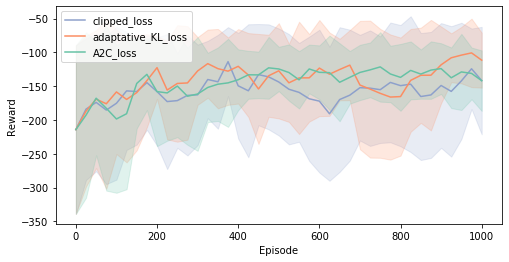

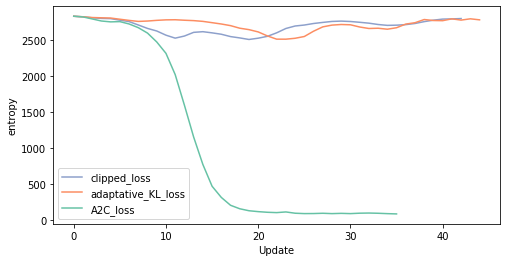

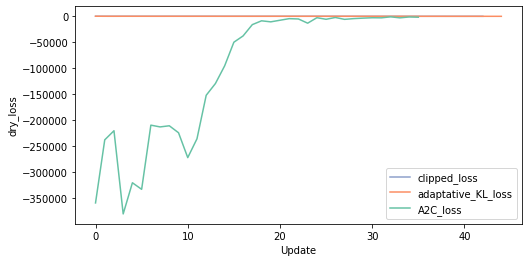

In [58]:
plot_sumup(rewards_list,loss_list,config=config)

In [13]:
config["env"] = 'CartPole-v1'
print(config["lambda"]!=1)
rewards_list = []
loss_list = []
for loss in ["clipped_loss","adaptative_KL_loss","A2C_loss"]:
    print("-----------------"+loss+"-----------------")
    config["loss_name"]=loss
    print(config)
    agent = PPOAgent(config)
    
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

False
-----------------clipped_loss-----------------
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.2, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 10, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 42, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}
Loss :  clipped_loss
Episode 1/1000: Mean rewards: 19.9, Std: 8.5
Episode 25/1000: Mean rewards: 20.08, Std: 8.08
Episode 50/1000: Mean rewards: 20.7, Std: 10.55
Episode 75/1000: Mean rewards: 21.22, Std: 11.71
Episode 100/1000: Mean rewards

Episode 800/1000: Mean rewards: 422.96, Std: 107.71
Episode 825/1000: Mean rewards: 448.44, Std: 88.32
Episode 850/1000: Mean rewards: 480.28, Std: 52.02
Episode 875/1000: Mean rewards: 490.84, Std: 40.88
Episode 900/1000: Mean rewards: 487.48, Std: 49.83
Episode 925/1000: Mean rewards: 458.78, Std: 87.48
Episode 950/1000: Mean rewards: 476.76, Std: 60.33
Episode 975/1000: Mean rewards: 495.78, Std: 22.2
Episode 999/1000: Mean rewards: 500.0, Std: 0.0
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:02:33.234947


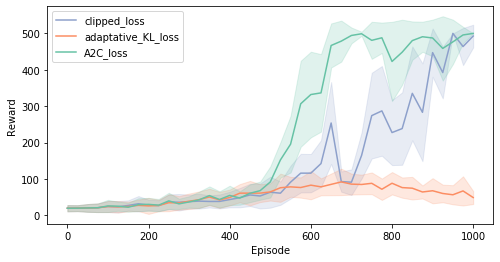

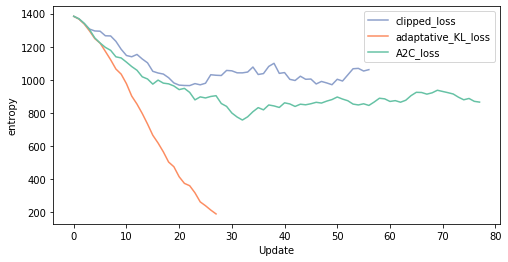

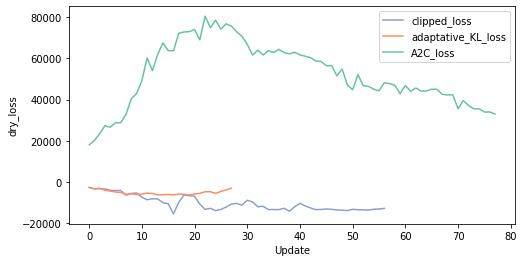

In [14]:
# lambda = 1 - no normalisation
plot_sumup(rewards_list,loss_list,config=config)

In [15]:
config["env"] = 'CartPole-v1'
config["lambda"]=0.95
print(config["lambda"]!=1)
rewards_list = []
loss_list = []
for loss in ["clipped_loss","adaptative_KL_loss","A2C_loss"]:
    print("-----------------"+loss+"-----------------")
    config["loss_name"]=loss
    print(config)
    agent = PPOAgent(config)
    
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

True
-----------------clipped_loss-----------------
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 0.95, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.2, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 10, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 42, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}
Loss :  clipped_loss
Episode 1/1000: Mean rewards: 19.9, Std: 8.5
Episode 25/1000: Mean rewards: 20.08, Std: 8.08
Episode 50/1000: Mean rewards: 20.7, Std: 10.55
Episode 75/1000: Mean rewards: 21.22, Std: 11.71
Episode 100/1000: Mean rewar

Episode 800/1000: Mean rewards: 142.42, Std: 24.92
Episode 825/1000: Mean rewards: 82.82, Std: 17.48
Episode 850/1000: Mean rewards: 88.76, Std: 24.12
Episode 875/1000: Mean rewards: 101.98, Std: 27.53
Episode 900/1000: Mean rewards: 118.28, Std: 46.62
Episode 925/1000: Mean rewards: 178.5, Std: 49.45
Episode 950/1000: Mean rewards: 227.3, Std: 18.31
Episode 975/1000: Mean rewards: 245.26, Std: 28.67
Episode 999/1000: Mean rewards: 212.0, Std: 12.86
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:01:40.682662


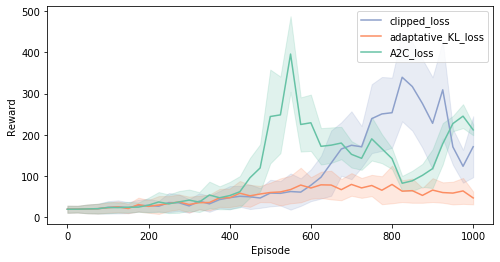

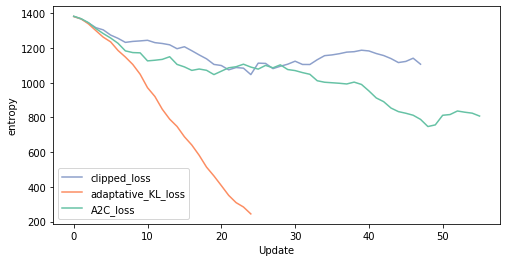

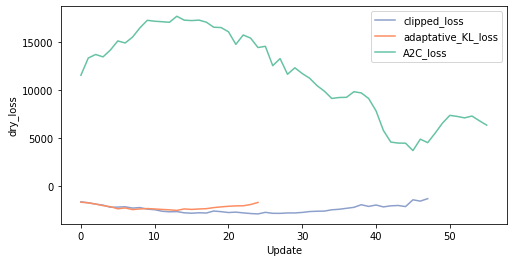

In [16]:
# lambda = 0.95 - no normalisation
plot_sumup(rewards_list,loss_list,config=config)

In [13]:
config["env"] = 'CartPole-v1'
config["lambda"]=1
config["reward_norm"]=True
print(config["lambda"]!=1)
rewards_list = []
loss_list = []
for loss in ["clipped_loss","adaptative_KL_loss","A2C_loss"]:
    print("-----------------"+loss+"-----------------")
    config["loss_name"]=loss
    print(config)
    agent = PPOAgent(config)
    
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

False
-----------------clipped_loss-----------------
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.2, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'reward_norm': True, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 10, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 42, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}
Loss :  clipped_loss
Episode 1/1000: Mean rewards: 19.9, Std: 8.5
Episode 25/1000: Mean rewards: 20.08, Std: 8.08
Episode 50/1000: Mean rewards: 20.7, Std: 10.55
Episode 75/1000: Mean rewards: 21.22, Std: 11.71
Episode 1

Episode 850/1000: Mean rewards: 10.48, Std: 2.17
Episode 875/1000: Mean rewards: 10.72, Std: 2.33
Episode 900/1000: Mean rewards: 11.68, Std: 3.64
Episode 925/1000: Mean rewards: 10.32, Std: 1.48
Episode 950/1000: Mean rewards: 10.42, Std: 1.69
Episode 975/1000: Mean rewards: 10.18, Std: 1.4
Episode 999/1000: Mean rewards: 10.34, Std: 1.98
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:00:13.113108


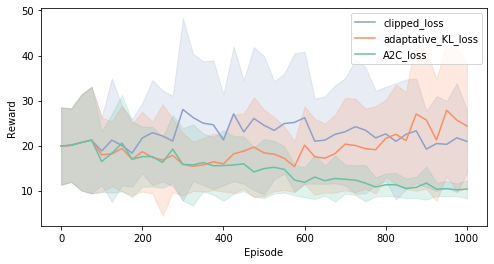

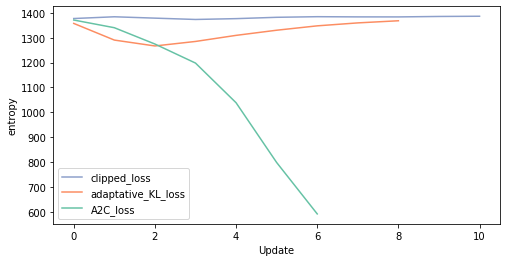

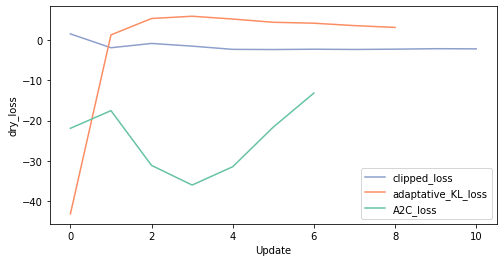

In [14]:
# lambda = 1 - reward normalisation -> Foir completement
plot_sumup(rewards_list,loss_list,config=config)

In [15]:
config["env"] = 'CartPole-v1'
print(config["lambda"]!=1)
rewards_list = []
loss_list = []
for loss in ["clipped_loss","adaptative_KL_loss","A2C_loss"]:
    print("-----------------"+loss+"-----------------")
    config["loss_name"]=loss
    print(config)
    agent = PPOAgent(config)
    
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

False
-----------------clipped_loss-----------------
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.2, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'reward_norm': False, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2000, 'batch_size': 10, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 42, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}
Loss :  clipped_loss
Episode 1/1000: Mean rewards: 19.9, Std: 8.5
Episode 25/1000: Mean rewards: 20.08, Std: 8.08
Episode 50/1000: Mean rewards: 20.7, Std: 10.55
Episode 75/1000: Mean rewards: 21.22, Std: 11.71
Episode 

Episode 750/1000: Mean rewards: 359.14, Std: 113.9
Episode 775/1000: Mean rewards: 378.16, Std: 117.04
Episode 800/1000: Mean rewards: 437.54, Std: 73.41
Episode 825/1000: Mean rewards: 449.18, Std: 75.28
Episode 850/1000: Mean rewards: 437.66, Std: 74.92
Episode 875/1000: Mean rewards: 324.46, Std: 79.13
Episode 900/1000: Mean rewards: 215.02, Std: 62.96
Episode 925/1000: Mean rewards: 113.0, Std: 18.81
Episode 950/1000: Mean rewards: 56.68, Std: 11.45
Episode 975/1000: Mean rewards: 56.3, Std: 9.9
Episode 999/1000: Mean rewards: 44.54, Std: 8.08
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:02:26.912014


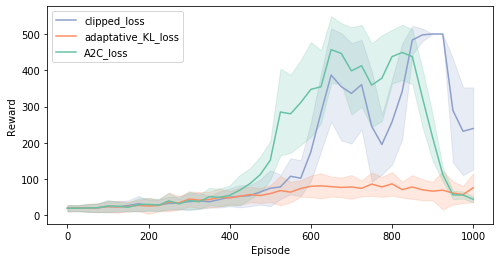

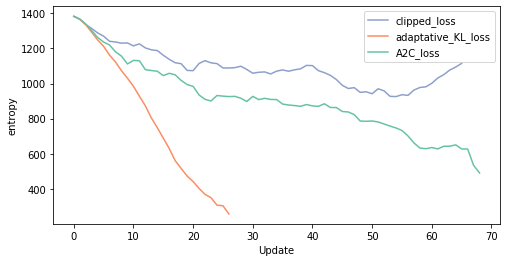

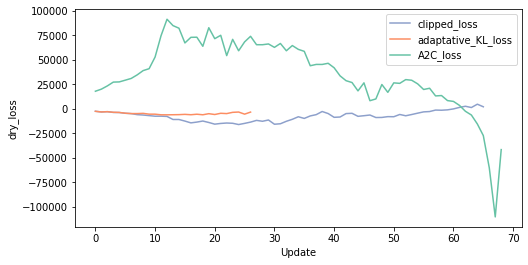

In [16]:
# No norm, lambda = 1, new optimisation loop
plot_sumup(rewards_list,loss_list,config=config)

In [53]:
config["env"] = 'CartPole-v1'
print(config["lambda"]!=1)
config['batch_size'] = 128
rewards_list = []
loss_list = []
for loss in ["clipped_loss","adaptative_KL_loss","A2C_loss"]:
    print("-----------------"+loss+"-----------------")
    config["loss_name"]=loss
    print(config)
    agent = PPOAgent(config)
    
    rewards, loss = agent.training(config["epochs"], config["optimize_every"], config["max_episodes"], config["max_steps"])
    rewards_list.append(rewards)
    loss_list.append(loss)

False
-----------------clipped_loss-----------------
{'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.2, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'reward_norm': False, 'epochs': 4, 'max_episodes': 1000, 'max_steps': 300, 'optimize_every': 2048, 'batch_size': 128, 'loss_name': 'clipped_loss', 'color': {'A2C_loss': (0.4, 0.7607843137254902, 0.6470588235294118), 'adaptative_KL_loss': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'clipped_loss': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}, 'seed': 42, 'reset_val': None, 'solved_reward': {'LunarLander-v2': 230, 'MountainCarContinuous-v0': 300, 'CartPole-v1': 300, 'MountainCar-v0': 300}}
Loss :  clipped_loss
Episode 1/1000: Mean rewards: 19.9, Std: 8.5
Episode 25/1000: Mean rewards: 20.08, Std: 8.08
Episode 50/1000: Mean rewards: 20.7, Std: 10.55
Episode 75/1000: Mean rewards: 21.22, Std: 11.71
Episode

Episode 800/1000: Mean rewards: 500.0, Std: 0.0
Episode 825/1000: Mean rewards: 500.0, Std: 0.0
Episode 850/1000: Mean rewards: 500.0, Std: 0.0
Episode 875/1000: Mean rewards: 500.0, Std: 0.0
Episode 900/1000: Mean rewards: 500.0, Std: 0.0
Episode 925/1000: Mean rewards: 500.0, Std: 0.0
Episode 950/1000: Mean rewards: 500.0, Std: 0.0
Episode 975/1000: Mean rewards: 500.0, Std: 0.0
Episode 999/1000: Mean rewards: 500.0, Std: 0.0
The training was done over a total of 1000 episodes
Total time ellapsed during training :  0:05:02.188935


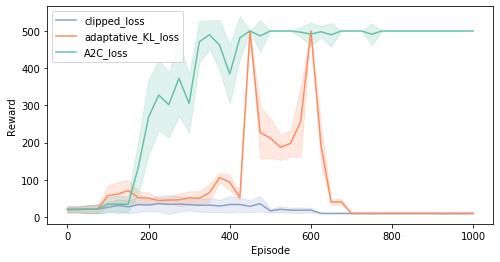

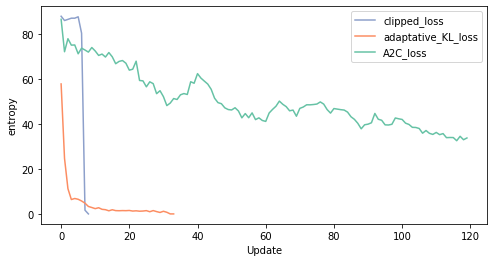

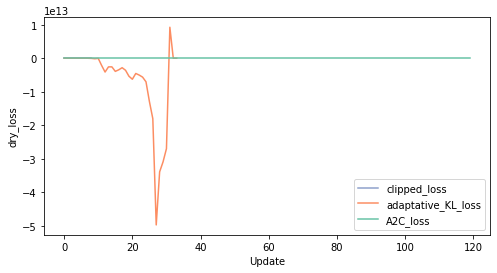

In [54]:
# No norm, lambda = 1, new optimisation loop, deterministic batch optim (128)
plot_sumup(rewards_list,loss_list,config=config)